In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import joblib

expense_data = pd.read_csv("~/Downloads/Expense Sheet - Categorized.csv");
expense_data.head

#X = expense_data.drop(columns=['Timestamp', 'Amount', 'Month', 'Year', 'Category']);
#y = expense_data['Category'];
#X.head



<bound method NDFrame.head of                 Timestamp              Head Amount Comment  Year  Month  \
0       1/1/2007 18:47:30             Dummy    NaN     NaN  2007      1   
1       1/1/2008 18:47:30             Dummy    NaN     NaN  2008      1   
2       1/1/2009 18:47:30             Dummy    NaN     NaN  2009      1   
3       1/1/2010 18:47:30             Dummy    NaN     NaN  2010      1   
4       1/1/2011 18:47:30             Dummy    NaN     NaN  2011      1   
...                   ...               ...    ...     ...   ...    ...   
3889  12/19/2023 15:30:05              Milk    150     NaN  2023     12   
3890  12/19/2023 15:52:10          Grocery   1,376    Nuts  2023     12   
3891   12/20/2023 8:21:33  Electricity bill  2,013     NaN  2023     12   
3892  12/20/2023 11:06:52           Mutton     499     NaN  2023     12   
3893  12/20/2023 13:08:16          Haircut     997     NaN  2023     12   

      Category  
0        Other  
1        Other  
2        Other  
3

In [41]:
expense_data['category_id'] = expense_data['Category'].factorize()[0]
category_id_expense = expense_data[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_expense.values)
id_to_category = dict(category_id_expense[['category_id', 'Category']].values)
expense_data

,Timestamp,Head,Amount,Comment,Year,Month,Category,category_id
0,1/1/2007 18:47:30,Dummy,NaN,NaN,2007,1,Other,0
1,1/1/2008 18:47:30,Dummy,NaN,NaN,2008,1,Other,0
2,1/1/2009 18:47:30,Dummy,NaN,NaN,2009,1,Other,0
3,1/1/2010 18:47:30,Dummy,NaN,NaN,2010,1,Other,0
4,1/1/2011 18:47:30,Dummy,NaN,NaN,2011,1,Other,0
...,...,...,...,...,...,...,...,...
3889,12/19/2023 15:30:05,Milk,150,NaN,2023,12,Milk,13
3890,12/19/2023 15:52:10,Grocery,"1,376",Nuts,2023,12,Grocery,1
3891,12/20/2023 8:21:33,Electricity bill,"2,013",NaN,2023,12,Bills,5
3892,12/20/2023 11:06:52,Mutton,499,NaN,2023,12,Grocery,1


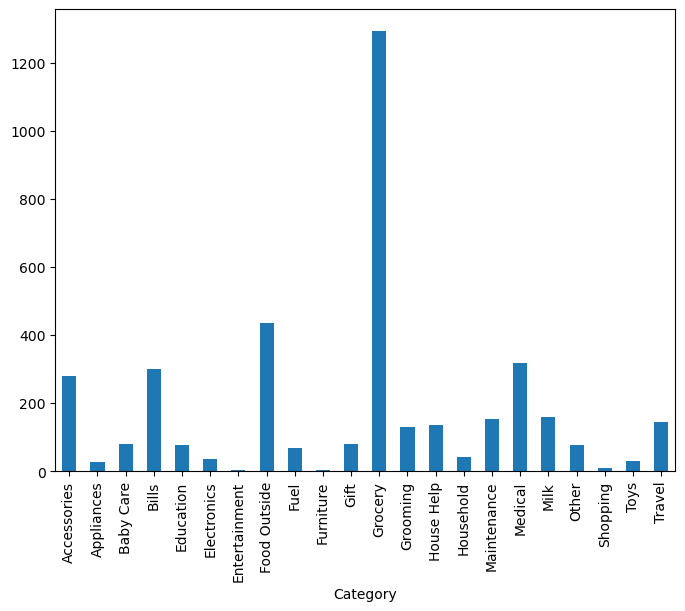

In [42]:
fig = plt.figure(figsize=(8,6))
expense_data.groupby('Category').Head.count().plot.bar(ylim=0)
plt.show()

In [43]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(expense_data.Head).toarray()
labels = expense_data.category_id
features.shape

(3894, 187)

In [44]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Accessories':
  . Most correlated unigrams:
. accessories
. shopping
  . Most correlated bigrams:
. baby dress
. cuckoo dress
# 'Appliances':
  . Most correlated unigrams:
. phone
. watch
  . Most correlated bigrams:
. mobile recharge
. washing machine
# 'Baby Care':
  . Most correlated unigrams:
. baby
. diapers
  . Most correlated bigrams:
. baby wipes
. baby care
# 'Bills':
  . Most correlated unigrams:
. broadband
. electricity
  . Most correlated bigrams:
. netflix recharge
. mobile recharge
# 'Education':
  . Most correlated unigrams:
. book
. xerox
  . Most correlated bigrams:
. doctor consultation
. mobile recharge
# 'Electronics':
  . Most correlated unigrams:
. battery
. electronics
  . Most correlated bigrams:
. mobile recharge
. washing machine
# 'Entertainment':
  . Most correlated unigrams:
. groceries
. amazon
  . Most correlated bigrams:
. doctor consultation
. mobile recharge
# 'Food Outside':
  . Most correlated unigrams:
. water
. snacks
  . Most correlated bigram

In [45]:
X_train, X_test, y_train, y_test = train_test_split(expense_data['Head'], expense_data['Category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LogisticRegression().fit(X_train_tfidf, y_train)

In [46]:
results = clf.predict(count_vect.transform(["pooja"]))
#prob_per_class_dictionary = dict(zip(model.classes_, results))

print(results)

['Grocery']


/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/a

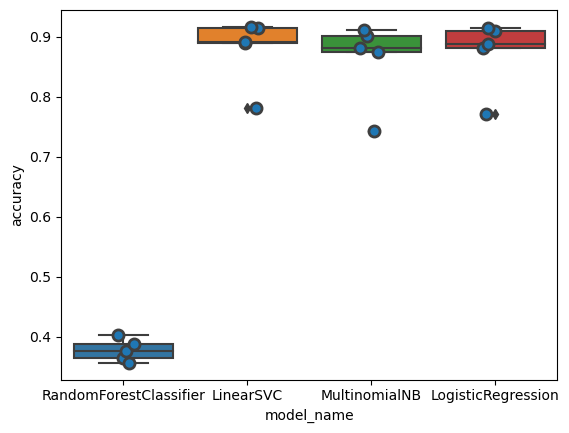

In [47]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [48]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.878791
LogisticRegression        0.873399
MultinomialNB             0.862100
RandomForestClassifier    0.377510
Name: accuracy, dtype: float64

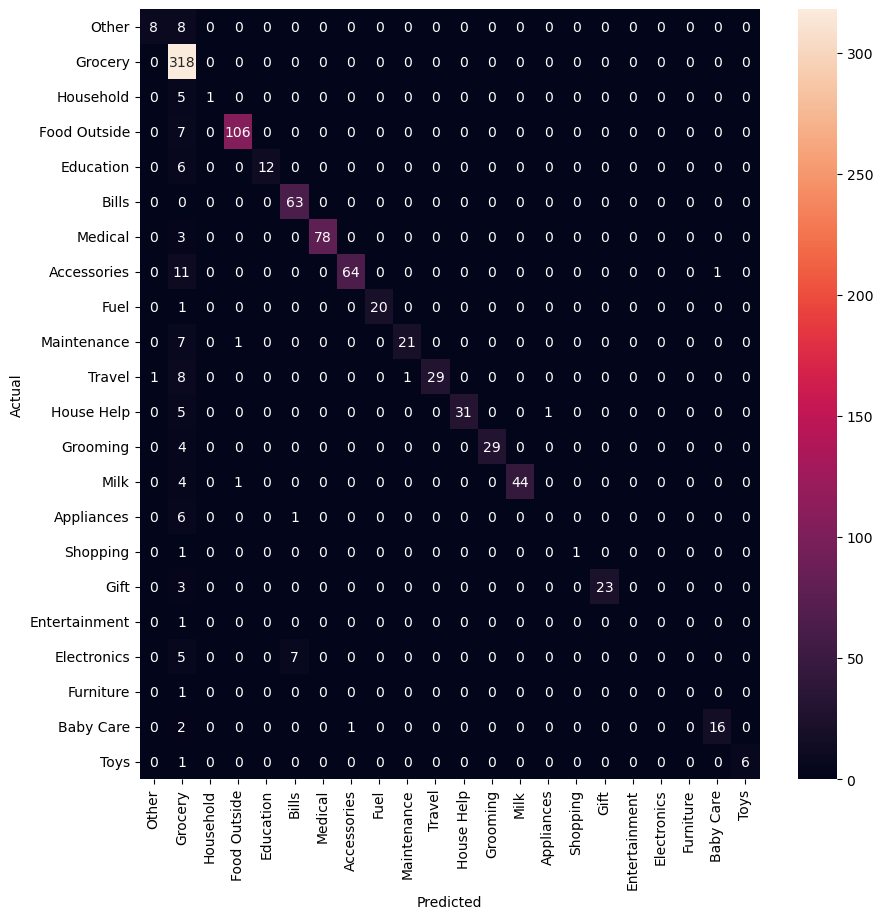

In [49]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, expense_data.index, test_size=0.25, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_expense.Category.values, yticklabels=category_id_expense.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [50]:
#pd.options.display.float_format = '{:,.2f}'.format
#test_data = pd.read_csv("~/Downloads/Expense Sheet - Categorized.csv").drop(columns=['Timestamp', 'Amount', 'Month', 'Year', 'Category', 'Comment']);
test_data = pd.read_csv("~/Downloads/Expense Sheet - Categorized.csv")
test_data.head()
print()

#expense_data['category_id'] = expense_data['Category'].factorize()[0]
#clf.predict(count_vect.transform(list(test_data)))
#test_data['predicted'] = clf.predict(test_data['Head'].factorize()[0])

#test_data.groupby(['predicted']).sum()
#test_data.groupby(['predicted']).sum().plot.pie( subplots=True,figsize=(5, 5))

In [54]:
joblib.dump(clf, '/Users/aloksingh/git/expense-catecorization/expense-categorization-mdl.joblib');